In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# Load the VGG19 model
vgg19 = models.vgg19(pretrained=True).features

# Freeze model weights to avoid training them
for param in vgg19.parameters():
    param.requires_grad = False
    
# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg19.to(device)

# hyperparams
epochs = 1000

/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
def load_image(img_path, max_size=400, shape=None):
    image = Image.open(img_path).convert('RGB')
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    if shape is not None:
        size = shape
    
    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    # add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    return image.to(device)

In [4]:
print(vgg19)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [5]:
# Function to extract features from images
def get_features(image, model, layers=None):
    if layers is None:
        layers = {
            '0': 'conv1_1',
            '5': 'conv2_1',
            '10': 'conv3_1',  # convX_Y (X: conv block of the VGG, Y: layer within the block)
            '19': 'conv4_1',
            '21': 'conv4_2',  # content representation
            '28': 'conv5_1'
        }
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

In [6]:
# Function to calculate the Gram matrix
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

In [7]:
# Load content and style images
content = load_image("prova_contingut.jpg")
style = load_image("prova_estil.jpg", shape=content.shape[2:])

In [8]:
# Initialize a target image
target = content.clone().requires_grad_(True).to(device)
optimizer = optim.Adam([target], lr=0.003)

In [9]:
# Style weights
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2
                 }
content_weight = 1  # Adjust as needed
style_weight = 1e6  # Adjust as needed

In [10]:
content_features = get_features(content, vgg19)
style_features = get_features(style, vgg19)
style_grams = {}
for layer in style_weights:
    style_grams[layer] = gram_matrix(style_features[layer])

In [11]:
# Function to calculate content and style loss
def calculate_losses(target_features, content_features, style_grams, style_weights, content_weight, style_weight):
    style_loss = 0
    content_loss = 0
    
    for layer in style_weights:
        # Calculate style loss for each of the selected layers
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_grams[layer]) ** 2)
        style_loss += layer_style_loss / (target_feature.shape[1] * target_feature.shape[2] * target_feature.shape[3])
    
    # Calculate content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)
    
    # Combine losses
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    return total_loss

In [12]:
# Example of how to use this function in your training loop
for i in range(epochs):
    target_features = get_features(target, vgg19)

    
    # Calculate losses
    total_loss = calculate_losses(target_features, content_features, style_grams, style_weights, content_weight, style_weight)
    
    # Optimization step
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if i % 50 == 0:
        print(f"Epoch {i}, Total Loss: {total_loss.item()}")

Epoch 0, Total Loss: 287522976.0
Epoch 50, Total Loss: 150180544.0
Epoch 100, Total Loss: 116173304.0
Epoch 150, Total Loss: 96875544.0
Epoch 200, Total Loss: 83113616.0
Epoch 250, Total Loss: 72633456.0
Epoch 300, Total Loss: 64506148.0
Epoch 350, Total Loss: 58162976.0
Epoch 400, Total Loss: 53177624.0
Epoch 450, Total Loss: 49161484.0
Epoch 500, Total Loss: 45838988.0
Epoch 550, Total Loss: 42998712.0
Epoch 600, Total Loss: 40516852.0


KeyboardInterrupt: 

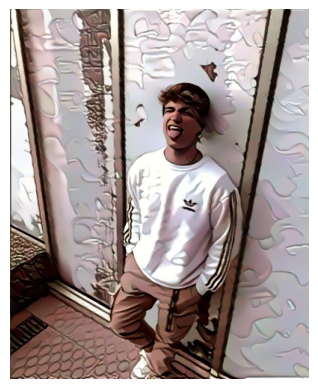

In [13]:
# Convert the target tensor back to an image format
def tensor_to_image(tensor):
    # Clone the tensor to detach it from the computation graph
    image = tensor.clone().detach().cpu().squeeze()
    # Convert the tensor to a numpy array
    image = image.numpy().transpose(1, 2, 0)
    # Denormalize the image
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    # Clip the image pixel values to be between 0 and 1
    image = np.clip(image, 0, 1)
    return image

# Display the target image
plt.figure()
plt.imshow(tensor_to_image(target))
plt.axis('off')
plt.show()
